In [15]:
# DQN for CartPole-v1 using PyTorch
# This program demonstrates a Deep Q-Network agent solving the
# classic control problem "CartPole-v1" from the Gymnasium library.

# --- 1. Imports ---
# We need gymnasium for the environment, PyTorch for the neural network,
# numpy for numerical operations, and collections.deque for the replay buffer.
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import collections
import random
import os
import matplotlib.pyplot as plt
# --- 2. Hyperparameters ---
# These are the key parameters we can tune to improve the agent's performance.
GAMMA = 0.99                # Discount factor for future rewards
LEARNING_RATE = 0.001       # Learning rate for the Adam optimizer
MEMORY_SIZE = 10000         # Max size of the replay buffer
BATCH_SIZE = 64             # Number of experiences to sample from memory for training
EPSILON_START = 1.0         # Starting value of epsilon for exploration
EPSILON_END = 0.01          # Minimum value of epsilon
EPSILON_DECAY = 0.995       # Rate at which epsilon decays
TARGET_UPDATE_FREQUENCY = 10 # How often (in episodes) to update the target network

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 3. ReplayBuffer Class (Same as before) ---
# The replay buffer stores past experiences and is framework-agnostic.
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# --- 4. PyTorch Q-Network ---
# We define our neural network using PyTorch's nn.Module.
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )

    def forward(self, x):
        """Defines the forward pass of the network."""
        return self.net(x)

# --- 5. DQNAgent Class using PyTorch ---
# This class encapsulates the agent's logic.
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.epsilon = EPSILON_START

        # Main Model: gets trained every step
        self.model = QNetwork(state_size, action_size).to(device)
        # Target Model: predicts Q-values for the next state.
        self.target_model = QNetwork(state_size, action_size).to(device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

    def update_target_model(self):
        """Copies the weights from the main model to the target model."""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Stores an experience in the replay buffer."""
        self.memory.add(state, action, reward, next_state, done)

    def choose_action(self, state):
        """Chooses an action using an epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # We don't need to calculate gradients for action selection.
        with torch.no_grad():
            act_values = self.model(state)
        # Get the action with the highest Q-value
        return np.argmax(act_values.cpu().data.numpy())

    def replay(self, batch_size):
        """Trains the main network using a batch of experiences."""
        if len(self.memory) < batch_size:
            return

        minibatch = self.memory.sample(batch_size)

        # Unzip the batch and convert to PyTorch tensors
        states = torch.from_numpy(np.vstack([e[0] for e in minibatch])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in minibatch])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in minibatch])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in minibatch])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in minibatch]).astype(np.uint8)).float().to(device)

        # Get Q-values for the actions that were actually taken
        current_q_values = self.model(states).gather(1, actions)

        # Get max Q-values for the next states from the target model
        # .detach() is used to prevent gradients from flowing into the target network
        next_q_values = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)

        # Calculate the target Q-values
        targets = rewards + (GAMMA * next_q_values * (1 - dones))

        # Calculate the loss (Mean Squared Error)
        loss = F.mse_loss(current_q_values, targets)

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        """Decays the epsilon value."""
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

    def load(self, name):
        """Loads weights into the model."""
        self.model.load_state_dict(torch.load(name))
        self.update_target_model()

    def save(self, name):
        """Saves the model's weights."""
        torch.save(self.model.state_dict(), name)

# --- 6. Main Training Loop ---
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    num_episodes = 5000  # Reduced number of episodes
    scores = []

    print("Starting training with PyTorch...")
    for e in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)

            shaped_reward = reward if not done else -10

            agent.remember(state, action, shaped_reward, next_state, done)
            state = next_state
            total_reward += 1

            if done:
                scores.append(total_reward)
                avg_score = np.mean(scores[-100:])
                if e % 10 == 0 and e > 0:
                  print(f"Episode: {e+1}/{num_episodes}, Score: {total_reward}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.2f}")
                break

        if len(agent.memory) > BATCH_SIZE:
            agent.replay(BATCH_SIZE)

        agent.decay_epsilon()

        if e % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_model()

        if e % 50 == 0 and e > 0:
            if not os.path.exists('models_pytorch'):
                os.makedirs('models_pytorch')
            agent.save(f"models_pytorch/cartpole-dqn-episode-{e}.pth")

    print("Training finished.")
    env.close()


Starting training with PyTorch...
Episode: 11/5000, Score: 26, Avg Score: 23.27, Epsilon: 0.95
Episode: 21/5000, Score: 16, Avg Score: 21.76, Epsilon: 0.90
Episode: 31/5000, Score: 19, Avg Score: 20.77, Epsilon: 0.86
Episode: 41/5000, Score: 11, Avg Score: 21.68, Epsilon: 0.82
Episode: 51/5000, Score: 22, Avg Score: 21.53, Epsilon: 0.78
Episode: 61/5000, Score: 20, Avg Score: 21.38, Epsilon: 0.74
Episode: 71/5000, Score: 44, Avg Score: 21.42, Epsilon: 0.70
Episode: 81/5000, Score: 10, Avg Score: 20.62, Epsilon: 0.67
Episode: 91/5000, Score: 9, Avg Score: 19.70, Epsilon: 0.64
Episode: 101/5000, Score: 19, Avg Score: 19.56, Epsilon: 0.61
Episode: 111/5000, Score: 10, Avg Score: 18.49, Epsilon: 0.58
Episode: 121/5000, Score: 10, Avg Score: 17.96, Epsilon: 0.55
Episode: 131/5000, Score: 25, Avg Score: 17.75, Epsilon: 0.52
Episode: 141/5000, Score: 19, Avg Score: 17.08, Epsilon: 0.50
Episode: 151/5000, Score: 19, Avg Score: 16.16, Epsilon: 0.47
Episode: 161/5000, Score: 27, Avg Score: 15.54

In [13]:
# --- 5. Visualization Function ---
def visualize_training(scores):
    """
    Plots the scores achieved per episode and a moving average.
    Args:
        scores (list): A list of scores for each episode.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='Episode Score')

    # Calculate and plot the moving average of the last 100 scores
    moving_avg = np.convolve(scores, np.ones(100)/100, mode='valid')
    plt.plot(np.arange(len(moving_avg)) + 99, moving_avg, label='100-Episode Avg Score', color='orange')

    plt.title('DQN Training Progress on CartPole-v1')
    plt.ylabel('Score (Timesteps)')
    plt.xlabel('Episode #')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


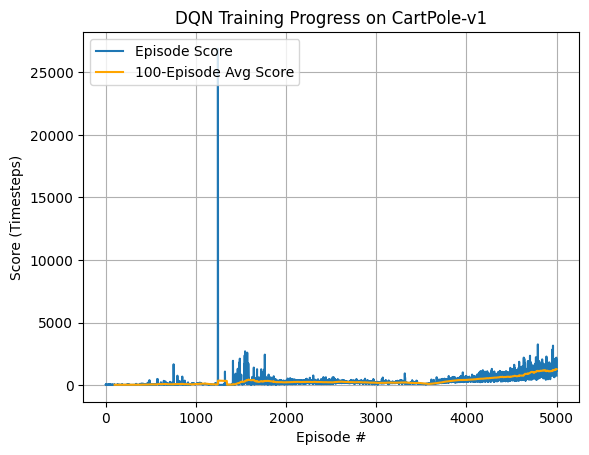

In [16]:
# Visualize the results
visualize_training(scores)

In [19]:
import gymnasium as gym
import torch
import numpy as np
import imageio
from PIL import Image
import os

# Hyperparameters (must match training)
GAMMA = 0.99
EPSILON_END = 0.01
MEMORY_SIZE = 10000  # Not used here but needed for agent initialization

# Define the QNetwork (must match training)
class QNetwork(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(state_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, action_size)
        )

    def forward(self, x):
        return self.net(x)

# Define the agent (minimal version for demonstration)
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = QNetwork(state_size, action_size)
        self.epsilon = EPSILON_END  # Use minimal epsilon for demonstration

    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            act_values = self.model(state)
        return np.argmax(act_values.numpy())

def record_demo(agent, env, output_path='demo.gif', max_steps=500):
    """Record a demonstration as GIF"""
    state, _ = env.reset()
    frames = []
    total_reward = 0

    for _ in range(max_steps):
        frame = env.render()  # Capture frame
        frames.append(Image.fromarray(frame))

        action = agent.choose_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    # Save as GIF
    frames[0].save(output_path,
                  save_all=True,
                  append_images=frames[1:],
                  duration=50,  # ms per frame
                  loop=0)
    print(f"Saved demo to {output_path}, Total reward: {total_reward}")

def record_video(agent, env, output_dir='recordings'):
    """Record a video using Gymnasium's recorder"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    env = gym.wrappers.RecordVideo(env, output_dir, name_prefix='demo')
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated

    env.close()
    print(f"Video saved in {output_dir}, Total reward: {total_reward}")

if __name__ == "__main__":
    # Initialize environment and agent
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    # Load your trained model (change the path as needed)
    model_path = "models_pytorch/cartpole-dqn-episode-1000.pth"  # Example
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}. Train first or check path.")

    agent.load(model_path)

    # Choose recording method (uncomment one)
    record_demo(agent, env)  # Creates demo.gif
    # record_video(agent, env)  # Creates MP4 in recordings/ folder

    env.close()

Saved demo to demo.gif, Total reward: 73.0
